In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import numpy as np
import pandas as pd
cwd=os.getcwd()
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from PIL import Image
from sklearn.preprocessing import LabelEncoder

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


**Reading from CSV file and creating a dataframe**

In [ ]:
df = pd.read_csv("file2.csv") 
   
# output the dataframe
print(df)

       Unnamed: 0       image  expression   valence   Arousal
0               0   84433.jpg           1  0.803329  0.111305
1               1  355266.jpg           0  0.031746 -0.007937
2               2  368459.jpg           1  0.761905 -0.547619
3               3  365975.jpg           6 -0.684787  0.179098
4               4   49570.jpg           1  0.690055 -0.131690
...           ...         ...         ...       ...       ...
27607       27607  209036.jpg           0  0.011484 -0.003828
27608       27608  350069.jpg           1  0.547619  0.000000
27609       27609  327174.jpg           1  0.681366  0.034451
27610       27610  371163.jpg           3  0.328751  0.547918
27611       27611   48905.jpg           1  0.750097  0.072590

[27612 rows x 5 columns]


**Loading data from dataframe**

In [ ]:
direc='Data/50k/images'

datagen_res=ImageDataGenerator(validation_split=0.2,preprocessing_function =tf.keras.applications.resnet.preprocess_input)

train_generator_res = datagen_res.flow_from_dataframe(
    dataframe=df,
    directory=direc,
    x_col="image",
    y_col=['valence', 'Arousal', 'expression'],
    image_size=(224,224),
    batch_size=5,
    class_mode="multi_output",
    subset='training',
    shuffle=True,
    seed=42)

valid_generator_res = datagen_res.flow_from_dataframe(
    dataframe=df,
    directory=direc,
    x_col="image",
    y_col=['valence', 'Arousal', 'expression'],
    image_size=(224,224),
    batch_size=5,
    class_mode="multi_output",
    subset='validation',
    shuffle=True,
    seed=42
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 22089 validated image filenames.
Found 5522 validated image filenames.


**Importing Resnet50 model and defining new layers for transfer learning**

In [ ]:
model2= ResNet50(include_top=False,
                   weights='imagenet')

for layer in model2.layers:
        layer.trainable=False
    
# add new classifier layers
outt =GlobalAveragePooling2D()(model2.layers[-1].output)
class2 = Dense(512, activation='relu')(outt)
class3=Dense(512, activation='relu')(class2)

exp_1 = Dense(100, activation='relu')(class3)
exp_2=Dense(100, activation='relu')(exp_1)
expression = Dense(8, activation='softmax',name='expression')(exp_2)

val_1 = Dense(100, activation='relu')(class3)
val_2=Dense(100, activation='relu')(val_1)
valence=keras.layers.Dense(1, activation='linear',name='valence')(val_2)

arrousal_1 = Dense(100, activation='relu')(class3)
arrousal_2=Dense(100, activation='relu')(val_1)
arrousal=keras.layers.Dense(1, activation='linear',name='arrousal')(arrousal_2)
# define new model
model2 = Model(inputs=model2.inputs, outputs=[expression,valence,arrousal])
# summarize
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

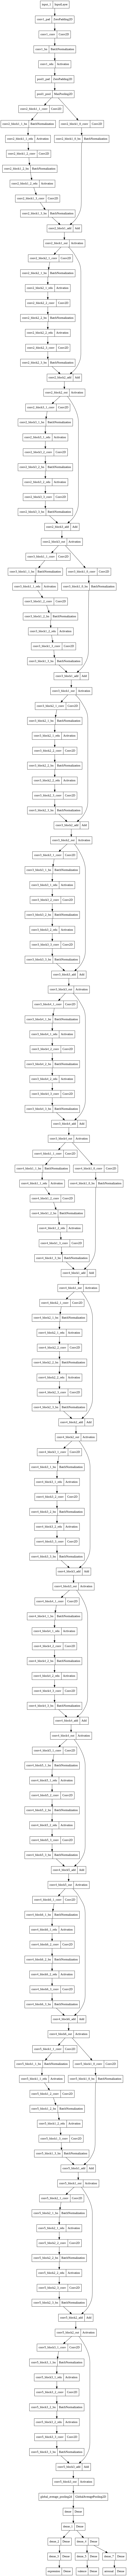

In [ ]:
keras.utils.plot_model(model2, "resnet.png")

In [ ]:
#loss and optimizer

def WeightedSoftmax(y_true, y_pred):
  class_weight=tf.convert_to_tensor(np.array([0.57261169,0.57229192,0.62097051,0.7573698,1.21360446,1.21360446,1.80900564,0.62412396,1.83002202]),dtype=tf.float32)
  unreduced_scee=tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  loss =unreduced_scee(y_true, y_pred)
  weight_mask=tf.gather(class_weight, y_true)
  loss=tf.math.multiplt(loss, weight_mask)
  loss=tf.reduce_mean

loss1=tf.keras.losses.SparseCategoricalCrossentropy(reduction="auto", name="CCE")
loss2=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
loss3=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
optim=keras.optimizers.Adam(lr=0.001)
metrics=['accuracy']

losses={
    "expression":loss1,
    "valence":loss2,
    "arrousal":loss3
}


model2.compile(loss=losses,optimizer=optim,metrics=metrics,loss_weights=[10,1,1])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

**Training and Validation**

In [ ]:
history=model2.fit(
    train_generator_res,
    batch_size=64,
    epochs=10,
    steps_per_epoch=1000,
    verbose=1,
    shuffle=True,
    validation_data=valid_generator_res,
    validation_steps=10,
    callbacks=[cp_callback]
)

Epoch 1/10
1000/1000 [==============================] - ETA: 0s - loss: 3.5071 - expression_loss: 4.6216e-06 - valence_loss: 0.1036 - arrousal_loss: 3.4035 - expression_accuracy: 0.0220 - valence_accuracy: 0.0306 - arrousal_accuracy: 0.4580
Epoch 1: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 2044s 2s/step - loss: 3.5071 - expression_loss: 4.6216e-06 - valence_loss: 0.1036 - arrousal_loss: 3.4035 - expression_accuracy: 0.0220 - valence_accuracy: 0.0306 - arrousal_accuracy: 0.4580 - val_loss: 3.1049 - val_expression_loss: 1.4210e-06 - val_valence_loss: 0.1037 - val_arrousal_loss: 3.0013 - val_expression_accuracy: 0.0200 - val_valence_accuracy: 0.0600 - val_arrousal_accuracy: 0.4400
Epoch 2/10
1000/1000 [==============================] - ETA: 0s - loss: 3.2938 - expression_loss: 1.4128e-06 - valence_loss: 0.0949 - arrousal_loss: 3.1989 - expression_accuracy: 0.0216 - valence_accuracy: 0.0306 - arrousal_accuracy: 0.4626
Epoch 2: saving model to training

In [ ]:
 model2.load_weights(checkpoint_path)

In [ ]:
import matplotlib.pyplot as plt

**Training learning curves**

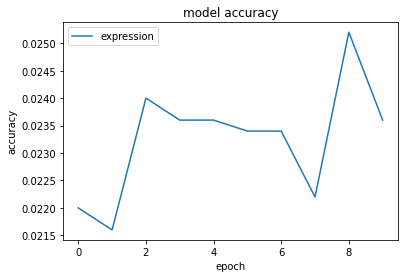

In [ ]:
plt.plot(history.history['expression_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['expression'], loc='upper left')
plt.show()

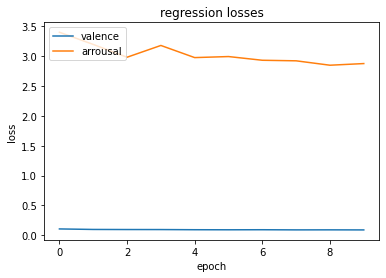

In [ ]:
plt.plot(history.history['valence_loss'])
plt.plot(history.history['arrousal_loss'])
plt.title('regression losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['valence','arrousal'], loc='upper left')
plt.show()

In [ ]:
model2.load_weights(checkpoint_path)

**Testing**

In [ ]:
df1 = pd.read_csv("test.csv") 

In [ ]:
direc='test/te/images'

datagen_res=ImageDataGenerator(validation_split=0.2,preprocessing_function =tf.keras.applications.resnet.preprocess_input)

In [ ]:
test_generator_res = datagen_res.flow_from_dataframe(
    dataframe=df1,
    directory=direc,
    x_col="image",
    y_col=['valence', 'Arousal', 'expression'],
    image_size=(224,224),
    batch_size=1,
    class_mode="multi_output",
    shuffle=True,
    seed=42)

Found 2000 validated image filenames.


In [ ]:
s_array = df1[["expression"]].to_numpy()

In [ ]:
loss,expression_loss,valence_loss,arrousal_loss,expression_accuracy,valence_accuracy,arrousal_accuracy = model2.evaluate(test_generator_res, verbose=1)

2000/2000 [==============================] - 475s 237ms/step - loss: 3.0531 - expression_loss: 1.2517e-09 - valence_loss: 0.0873 - arrousal_loss: 2.9657 - expression_accuracy: 0.0275 - valence_accuracy: 0.0425 - arrousal_accuracy: 0.4305


In [ ]:
expression_1,valence,arousal = model2.predict(test_generator_res, verbose=1)

2000/2000 [==============================] - 490s 245ms/step


In [ ]:
y_pred = np.argmax(expression_1, axis=1)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_pred, s_array, average='macro')

0.057024314936318016

**Performance measures**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, s_array))

              precision    recall  f1-score   support

           0       1.00      0.30      0.46      2000
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0

    accuracy                           0.30      2000
   macro avg       0.12      0.04      0.06      2000
weighted avg       1.00      0.30      0.46      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
